In [1]:
%pylab inline
import glob, os, sys, fnmatch
from astropy.io import fits
import astropy.table
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate 

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/python/')
import run_model

In [604]:
cont_files = glob.glob('/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/*_split_flux.fits')

In [4]:
hdulist = fits.open(cont_files[0])
ObsMeta = astropy.table.Table(hdulist[1].data)

In [4]:
Mhdu = fits.open('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.fits')
MetaData = astropy.table.Table(Mhdu[1].data)
def get_specnos(meta):
    plate = meta['PLATE']
    image = meta['IMG']
    this_meta = MetaData[(MetaData['PLATE'] == plate) & (MetaData['IMG'] == image) & ((MetaData['CAMERAS'] == 'b1')|(MetaData['CAMERAS'] == 'b2'))]
    specnos = this_meta['SPECNO']
    return np.array(specnos)

In [5]:
wave = np.linspace(360,630,(630-360)*10)
def make_mean_cont(hdulist, specnos, wave):
    spectra = []
    for specno in specnos:
        try:
            data = hdulist[str(specno)].data
            cont = interpolate.interp1d(data['WAVE'], data['CONT'], bounds_error=False, fill_value=0)
            spectra.append(cont(wave))
        except:
            pass
    return np.mean(spectra, axis = 0)

In [6]:
def plot_mean_observations(hdu_list):
    ObsMeta = astropy.table.Table(hdu_list[1].data)
    color=iter(cm.rainbow(np.linspace(0,1,7)))
    plt.figure()
    for observation in ObsMeta:
        Model = run_model.RunSkyModel(observation)
        specnos = get_specnos(observation)
        mean_cont = make_mean_cont(hdu_list, specnos)
        c=next(color)
        plt.plot(wave, mean_cont, '-', color = c, label = observation['IMG'])
        plt.plot(Model.wave_range, Model.total_flux, '--', color = c)
        plt.title("Plate: %d" % observation['PLATE'])
    plt.legend()
    plt.xlim(360,630)

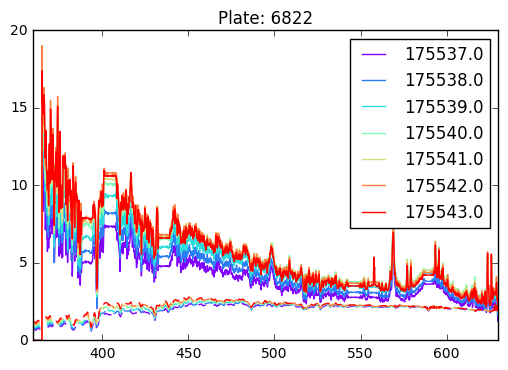

In [8]:
for filen in cont_files[0:1]:
    hdulist = fits.open(filen)
    plot_mean_observations(hdulist)

## Fit the spectra

In [96]:
from lmfit import models, Parameters, Parameter, Model
from lmfit.models import LinearModel, ConstantModel

In [110]:
import get_zodi_spectra as zodi
import get_scatt_moon as moon
import get_isl_spectra as isl

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
wave = np.linspace(360,630,(630-360)*10)

## 1) Fit full spectra

In [236]:
filen = np.random.choice(cont_files,1)[0]
hdulist = fits.open(filen)
ObsMeta = astropy.table.Table(hdulist[1].data)
observation = ObsMeta[0]

Z = zodi.ZodiSpectrum(observation)
Z.get_spectrum()
M = moon.MoonSpectrum(observation) 
M.get_spectrum()
I = isl.ISLSpectrum(observation)
I.get_spectrum()

specnos = get_specnos(observation)
mean_cont = make_mean_cont(hdulist, specnos, Z.wave_range)

def my_model(x, A, B, C, D, E, F, G):
    trans = Z.ext_curve**(Z.f_ext*D)
    zodi = A*Z.flux
    moon = B*M.flux
    isl = C*I.flux
    
    return F+moon+zodi+isl

In [237]:
mod = Model(my_model)
    
params = mod.make_params()

params.add('A', value = 10)
params.add('B', value = 10)
params.add('C', value = 10)
params.add('D', value = 100, min = 0.0001)
params.add('F', value = 0, min = 0)
#params.add('G', value = 1, min = 0.0001)
params.add('E', value = 10, min = 0.0001)
result = mod.fit(mean_cont, params, x = Z.wave_range)

In [238]:
result.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
A    -20.59     -inf      inf        0     True     None     None
B     12.02     -inf      inf        0     True     None     None
C     24.28     -inf      inf        0     True     None     None
D       100   0.0001      inf        0     True     None     None
E        10   0.0001      inf        0     True     None     None
F         0        0      inf        0     True     None     None
G      -inf     -inf      inf        0     True     None     None


(360, 630)

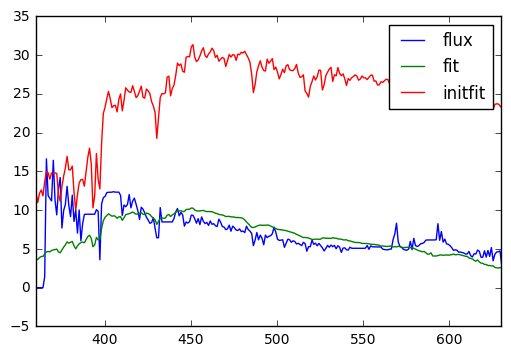

In [239]:
plt.plot(Z.wave_range, mean_cont, label = 'flux')
plt.plot(Z.wave_range, result.best_fit, label = 'fit')
plt.plot(Z.wave_range, result.init_fit, label = 'initfit')
plt.legend()
plt.xlim(360,630)

## 2) By wavelength

In [393]:
filen  = np.random.choice(cont_files,1)[0]
hdulist = fits.open(filen)
ObsMeta = astropy.table.Table(hdulist[1].data)
observation = ObsMeta[0]

Z = zodi.ZodiSpectrum(observation)
M = moon.MoonSpectrum(observation)
I = isl.ISLSpectrum(observation)

spectra = {}
for m in [Z,M,I]:
    spectra[m.name] = []

In [394]:
spectra

{'ISL': [], 'Moon': [], 'Zodi': []}

In [395]:
Cont_spectra = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]

    Z = zodi.ZodiSpectrum(observation)
    M = moon.MoonSpectrum(observation)
    I = isl.ISLSpectrum(observation)
            
    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)
    try:
        a = len(mc) 
        Cont_spectra.append(mc)
        for model_comp in [Z, M, I]:
            model_comp.get_spectrum()
            spectra[model_comp.name].append(model_comp.flux)
    except:
        print(filen)  

/Users/parkerf/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


/Users/parkerf/Research/SkyModel/BOSS_Sky/FitSpectra/split_files/4029_split_flux.fits


In [307]:
names = ['ISL', 'Moon', 'Zodi']

In [378]:
C = []
for c in Cont_spectra:
    

In [419]:
np.array(C).shape

(70, 680)

In [246]:
import statsmodels.api as sm

In [422]:
Results = []
for i, y in enumerate(np.array(C).T):
    X = []
    for name in names:
        X.append(np.array(spectra[name]).T[i])
    X = np.vstack(X).T
    x = sm.add_constant(X)
    model = sm.OLS(y, x)
    results = model.fit()
    p = results.params
    Results.append(p)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 1.          0.08043253  0.4010949   0.30848418]
 [ 1.          0.12706141  1.01951328  0.34976412]
 [ 1.          0.10968321  1.41827538  0.34328915]
 [ 1.          0.12226722  0.26078908  1.05108204]
 [ 1.          0.09214619  0.47373965  0.37934623]
 [ 1.          0.17382016  1.03666364  3.44586289]
 [ 1.          0.0914545   0.75818185  0.37050389]
 [ 1.          0.09319889  0.55708831  0.39421001]
 [ 1.          0.16317304  1.0259612   0.36673396]
 [ 1.          0.08963878  0.6199819   0.39892383]
 [ 1.          0.19011227  0.60495997  0.39308506]
 [ 1.          0.07169889  0.46134063  0.37864956]
 [ 1.          0.09412705  0.65756223  0.3842857 ]
 [ 1.          0.12179708  1.25346564  0.38200518]
 

LinAlgError: SVD did not converge

In [423]:
Results = np.vstack(Results)

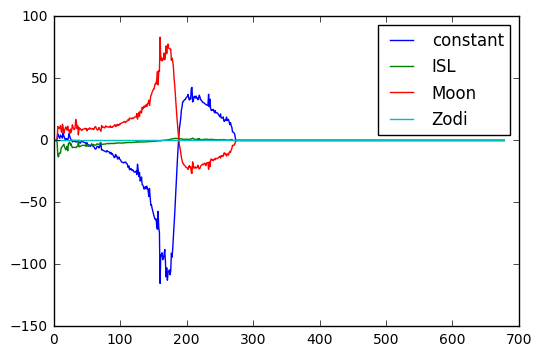

In [424]:
plt.plot(Results[:,0], label = 'constant')
plt.plot(Results[:,1], label = 'ISL')
plt.plot(Results[:,2], label = 'Moon')
plt.plot(Results[:,3], label = 'Zodi')
plt.legend()

In [282]:
from scipy.linalg import lstsq

In [465]:
def test_model(filen):
    Spectra = []

    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]

    Z = zodi.ZodiSpectrum(observation)
    M = moon.MoonSpectrum(observation)
    I = isl.ISLSpectrum(observation)

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)

    for model_comp in [Z, M, I]:
        model_comp.get_spectrum()
        Spectra.append(model_comp.flux[:-1])
        
    X = sm.add_constant(np.array(Spectra).T)
    res = np.dot(Results,X.T)
    mod = res.diagonal()
    
    return mc[:-1], mod

In [470]:
def plot_results(results):
    plt.figure()
    plt.plot(Z.wave_range[:-1], results[0], 'k-', label = 'data')
    plt.plot(Z.wave_range[:-1], results[1], label = 'fit')
    plt.legend()
    plt.xlim(360,630)

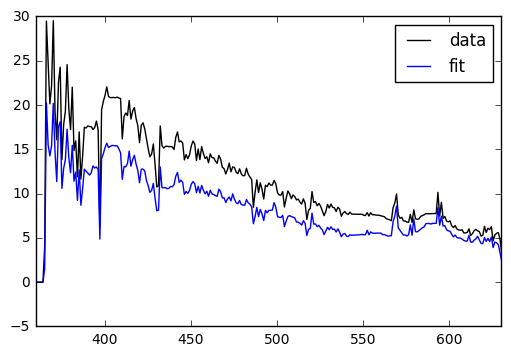

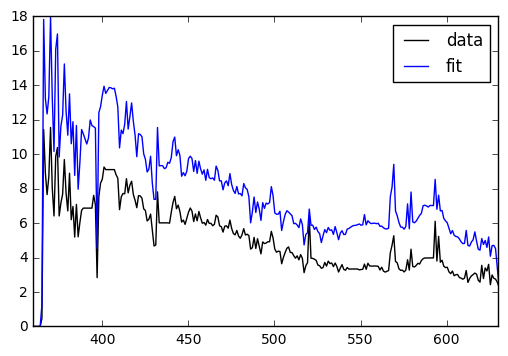

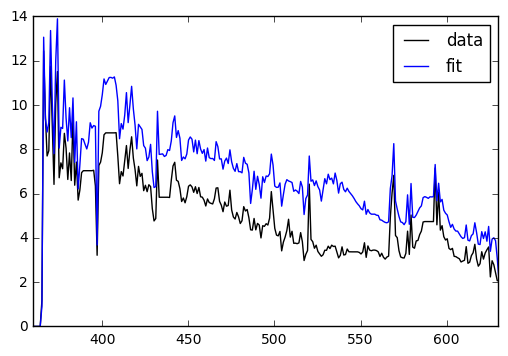

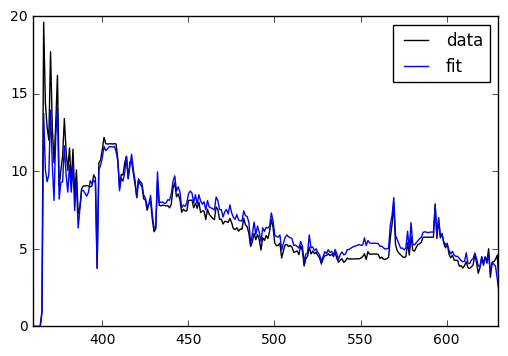

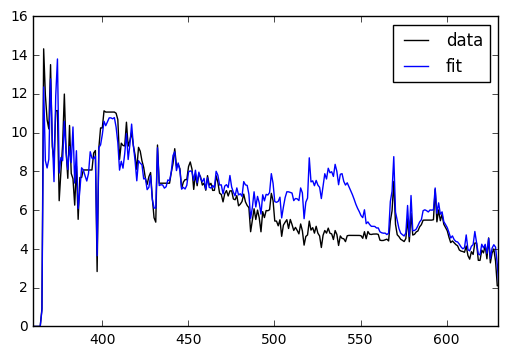

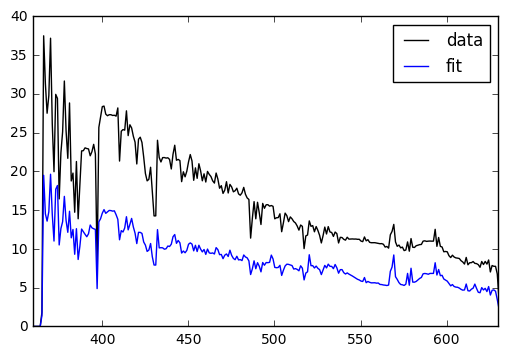

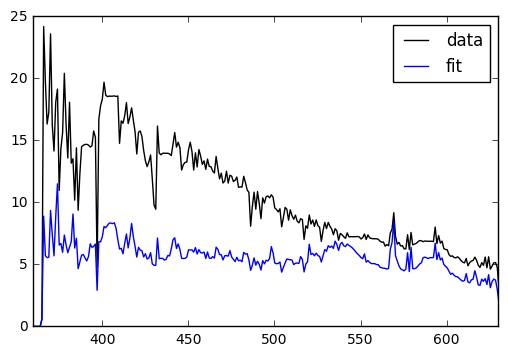

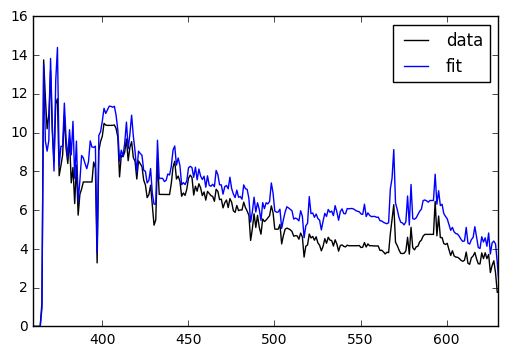

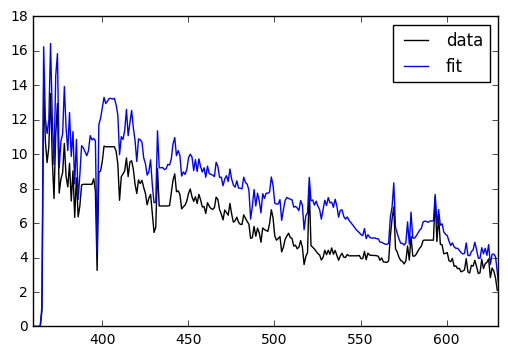

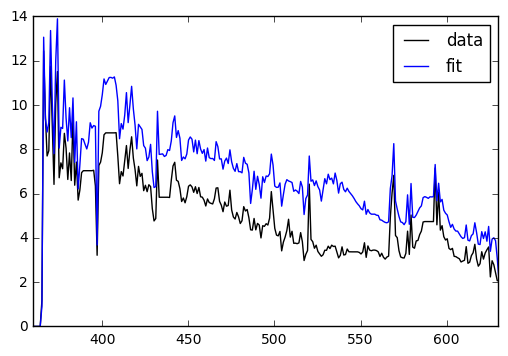

In [471]:
for filen in np.random.choice(cont_files,10):
    results = test_model(filen)
    plot_results(results)

## Fully linear model

In [740]:
XX = []
YY = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = np.array(ObsMeta[0])

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)
    
    #meta = observation[['MOON_ILL','AIRMASS' ,'AZ','AIRTEMP', 'DEWPOINT', 'DUSTA', 
    #                    'DUSTB', 'WINDD25M', 'WINDS25M', 'GUSTD', 'GUSTS', 'HUMIDITY', 
    #                    'PRESSURE', 'WINDD', 'WINDS','MOON_ALT', 'MOON_AZ', 'SUN_ALT', 
    #                    'SUN_AZ', 'MOON_D', 'MOON_SEP', 'SUN_MOON_SEP','ECL_LAT', 
    #                    'ECL_LON', 'GAL_LAT', 'GAL_LON','SEASON', 'HOUR', 'SOLARFLUX']]
    meta = observation[['MOON_ILL','AIRMASS' ,'MOON_ALT']]

    XX.append(meta.tolist())
    YY.append(mc)

In [640]:
np.vstack(XX).shape

(70, 29)

In [741]:
Results = []
for i, y in enumerate(np.vstack(YY).T):

    x = sm.add_constant(XX)
    model = sm.OLS(y, x)
    results = model.fit()
    p = results.params
    Results.append(p)

In [742]:
Results = np.vstack(Results)

In [743]:
names = ['MOON_ILL','AIRMASS' ,'MOON_ALT','CONSTANT']

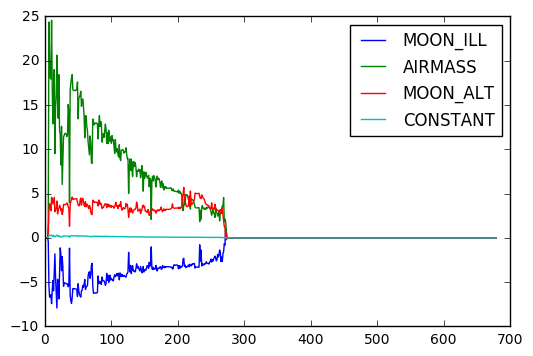

In [744]:
for i, r in enumerate(Results.T):
    plt.plot(r, label = names[i])
plt.legend()

In [756]:
def test_model(filen):
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = np.array(ObsMeta[0])

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, Z.wave_range)

    meta = observation[['MOON_ILL','AIRMASS' ,'MOON_ALT']]

    XX = np.hstack([meta.tolist(), 1])
    
    XXX = np.tile(np.array(XX), (Results.shape[0],1))

    res = np.dot(Results, XXX.T)
    mod = res.diagonal()
    plt.figure()
    plt.plot(Z.wave_range,mc, label = 'flux')
    plt.plot(Z.wave_range, mod, label = 'mod')
    plt.legend()
    
    return mc, mod


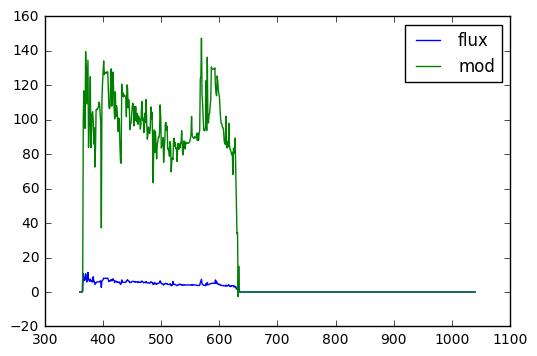

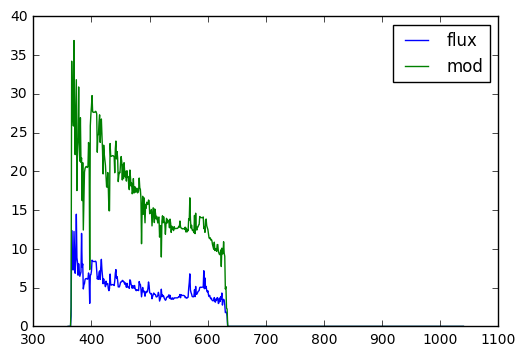

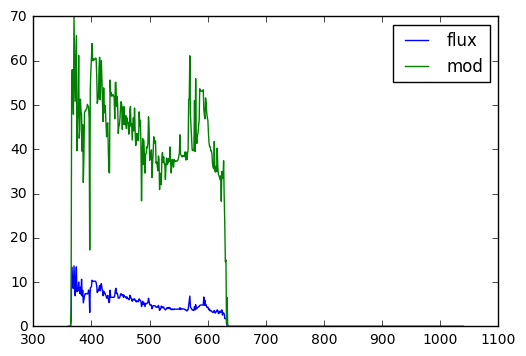

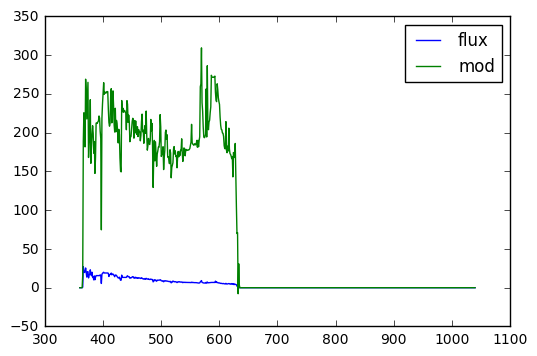

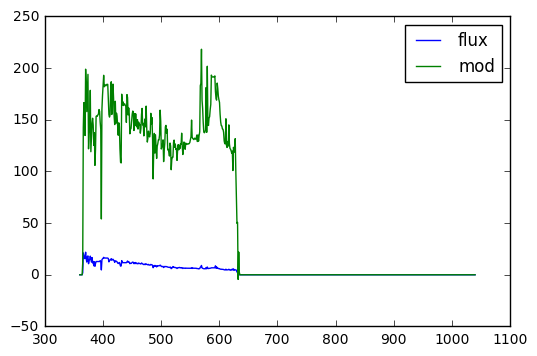

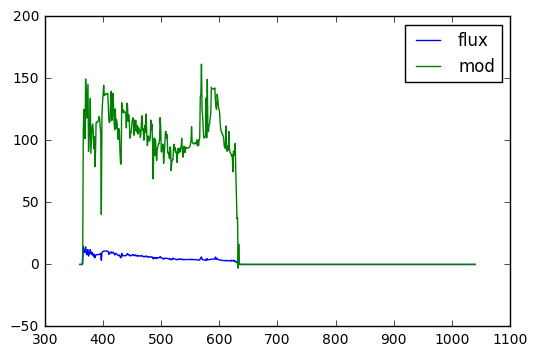

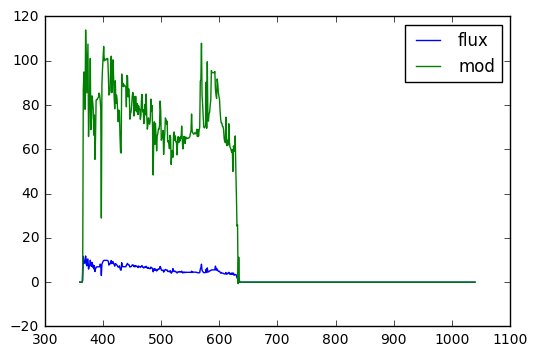

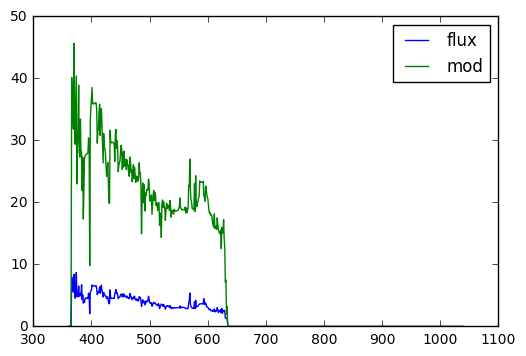

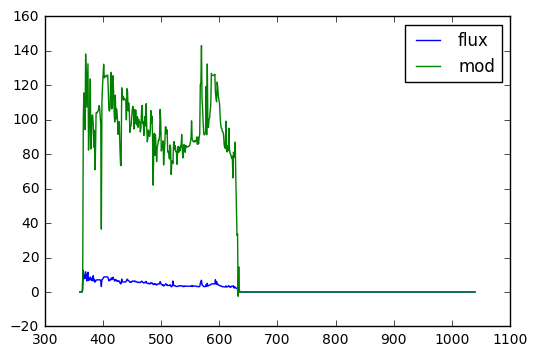

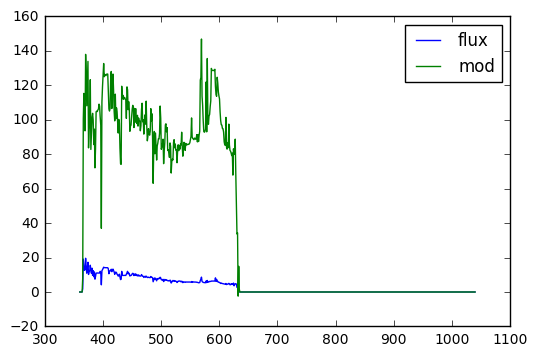

In [757]:
for filen in np.random.choice(cont_files,10):
    results = test_model(filen)

## 4) More complex nonlinear model

In [ ]:
def BrightModel(data):        
    def bright_sky_model(x, A, B, C, a1, a2, a3, a4, a5, a6, a7, a8):
        MoonPhase, k_V, MoonX, ObsX, MoonSep, I, V, zodi, isl = x

        m = -a1+a2*np.abs(MoonPhase)+a3*10**(-9)*MoonPhase**(4)
        I_V = 10**(-0.4*(m+a4))

        moon_ext = 10**(-0.4*k_V*MoonX)*(1-10**(-0.4*k_V*ObsX))

        fR = 10**(a5)*(a6+(np.cos(np.deg2rad(MoonSep)))**(2))
        fM = 10**(a7 - (MoonSep/a8))
        
        B = (fR+fM)*I_V*moon_ext
        V_scatt = (20.7233 - np.log(B)/34.08)/0.92104

        moon = I * 10 ** (-0.4*(V_scatt - V)) * np.pi*10**(17) 

        Zodi = A*zodi
        ISL = B*isl
        sky = moon + Zodi + ISL + C

        return sky
    
    mod = Model(bright_sky_model)
    params = mod.make_params()
    params.add('A', value = 1)
    params.add('B', value = 1)
    params.add('C', value = 0)
    
    params.add('a1', value = 12.73, min = 0, max = 20)
    params.add('a2', value = 0.025, min = .001, max = 1)
    params.add('a3', value = 4, min = 0) #4*10**(-9)
    params.add('a4', value = 16.57, min = 0, max = 20)
    params.add('a5', value = 5.36, min = 0, max = 10)
    params.add('a6', value = 1.06, min = 0, max = 5)
    params.add('a7', value = 6.15, min = 0, max = 10)
    params.add('a8', value = 40., min = 0, max = 100)
    
    
    
    y_values = Co
        
        
        
    
    xx = np.array([data['MOON_ILL'], data['MOON_SEP'], data['AIRMASS'],data['scatt_airmass'], data['raw_V'], 
      data['mean_ext'], data['ZODI'], data['SEASON'], data['DUSTB'], data['MOON_LAT'], data['AIRTEMP'], data['DEWPOINT'],
                  data['PRESSURE'], data['HOUR']])
    
    #print(mod.eval(params, x = xx))
    result = mod.fit(np.array(data['SKY_VALUE']), params, x = xx)
    print(result.fit_report())
    return result

In [763]:
from sky_model import SkyModel

In [766]:
Data = []
Cont_spectra = []
for filen in cont_files:
    hdulist = fits.open(filen)
    ObsMeta = astropy.table.Table(hdulist[1].data)
    observation = ObsMeta[0]
    ThisObs = SkyModel(observation)
    ThisObs.run_model()

    specnos = get_specnos(observation)
    mc = make_mean_cont(hdulist, specnos, ThisObs.Model['wave_range'])
    Cont_spectra.append(mc)
    
    zodi = ThisObs.Model['Zodi']
    isl = ThisObs.Model['ISL']
    moonphase = np.ones(len(zodi))*ThisObs.ObsMeta['MOON_PHASE']
    moonx = np.ones(len(zodi))*ThisObs.M.ObsMeta['MOON_X']
    obsx = np.ones(len(zodi))*ThisObs.M.ObsMeta['OBS_X']
    moonsep = np.ones(len(zodi))*ThisObs.M.ObsMeta['MOON_SEP']
    k_V = np.ones(len(zodi))*ThisObs.M.k_V
    I = ThisObs.M.I
    V = np.ones(len(zodi))*ThisObs.M.V
    
    Data.append([moonphase, k_V, moonx, obsx, moonsep, I, V, zodi, isl])

In [773]:
Cont_spectra = np.array(Cont_spectra)

In [774]:
Cont_spectra.shape

(0,)

In [767]:
Data = np.array(Data)

In [775]:
This_data = []

(70, 9)

In [789]:
for x in Data[0]:
    try:
        print(len(x))
    except:
        print(x)

680
0.151117727691
680
680
680
680
-16.0798979665
680
680
